In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import cvxpy as cp
from numpy import linalg as LA
import pprint
from lap import lapjv
import copy

# percent flip
c = 0.1
n=10


In [2]:
#Construct a n-degree permutation matrix 

def permu(N):
    E=np.identity(N)
    permutation = np.random.permutation(N)
    P=np.zeros([N,N]) #initialize the permutation matrix
     
    for i in range(0,N):
        P[i]=E[permutation[i]]
    
    
    return P.astype(int)

In [3]:
# Generate a random aj matrix for unweighted and undirected graph
def generate_aj_matrix(n):
    id = np.identity(n)
    ones_mat=np.ones((n, n)) 
    arr = ones_mat - id
    #print(arr)
    for i in range(n):
        for j in range(i+1,n):
            arr[i][j] = random.choice([0,1])
            arr[j][i] = arr[i][j]
    return arr

In [4]:
# Define function with flip percent = c%
def flip(M,c):
    n = len(M)
    for i in range(n):
        for j in range(i+1,n):
            rand_val = random.uniform(0,1)
            if rand_val < c:
                ori = M[i][j]
                M[i][j] = 1-ori
                M[j][i] = M[i][j]
    return M
    
    
    


In [5]:
np.random.seed(3)
A = generate_aj_matrix(10)
print("A= \n",A)

A= 
 [[0. 1. 1. 0. 0. 0. 1. 1. 0. 0.]
 [1. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 1. 1. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 1. 1. 1.]
 [0. 1. 1. 1. 0. 1. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 1. 1. 0. 0.]
 [1. 1. 0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 1. 1. 1. 0. 1. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0. 1. 1. 0. 1.]
 [0. 1. 0. 1. 1. 0. 0. 0. 1. 0.]]


P= 
 [[0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]]


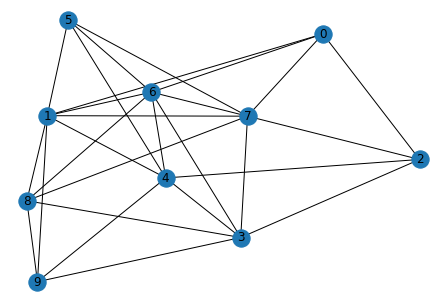

In [6]:
GA= nx.from_numpy_matrix(A)
nx.draw(GA,with_labels = True)
plt.savefig('A_for_fliped', dpi=500)

P_1 = permu(10)
print("P= \n",P_1)



B_ori= 
 [[0. 0. 0. 1. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1. 1. 0. 0. 1.]
 [1. 1. 1. 0. 1. 1. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
 [1. 0. 1. 1. 1. 0. 0. 0. 1. 1.]
 [1. 0. 0. 0. 1. 1. 0. 0. 1. 0.]
 [1. 1. 0. 0. 1. 1. 1. 1. 0. 1.]
 [0. 0. 1. 0. 1. 1. 1. 0. 1. 0.]]
B_flip= 
 [[0. 0. 0. 1. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [1. 1. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 1. 1. 0. 1. 1.]
 [0. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
 [1. 0. 1. 1. 1. 0. 0. 0. 1. 1.]
 [1. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
 [1. 1. 0. 0. 1. 1. 1. 1. 0. 1.]
 [0. 0. 0. 0. 1. 1. 1. 0. 1. 0.]]


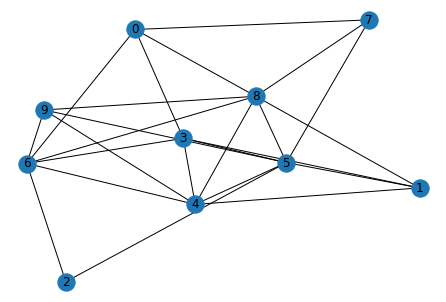

In [7]:
B_ori = np.matmul(P_1, np.matmul(A,P_1.T))
#print(B.transpose())
print("B_ori= \n",B_ori)
B = flip(B_ori,c)
print("B_flip= \n",B)

GB = nx.from_numpy_matrix(B)
nx.draw(GB,with_labels = True)
plt.savefig('B_fliped', dpi=500)


In [8]:
# Define and solve the CVXPY problem.
P = cp.Variable((10,10))
arr = cp.expressions.constants.Constant([[1 for i in range(10)]])
constraints = [P.__matmul__(arr) == arr, P.T.__matmul__(arr) == arr, cp.min(P)>=0]
prob = cp.Problem(cp.Minimize((cp.norm(P.__matmul__(A)-(P.T.__matmul__(B.T)).T, 'fro'))**2), constraints)
prob.solve()


# Print result.
print("The norm of the residual is", prob.value)
print("The optimal P is")
pp = pprint.PrettyPrinter(depth=6)
pp.pprint(P.value)
P_step_1 = copy.deepcopy(P.value)
for i in range(len(P_step_1)):
    for j in range(len(P_step_1)):
        P_step_1[i][j] = round(P_step_1[i][j],2)
        
print(P_step_1)


The norm of the residual is 1.2074465750097982
The optimal P is
array([[ 9.98679620e-02,  3.49290499e-11,  2.98957650e-01,
         1.71728831e-01,  1.24870503e-01,  9.47525949e-11,
         1.64266022e-03,  3.82951393e-02,  1.25333227e-01,
         1.39304028e-01],
       [ 2.05921190e-01,  1.13647001e-10,  8.10547754e-11,
         5.09556259e-02,  3.99361332e-11,  2.38936736e-01,
         8.30688438e-02,  6.66474125e-11,  2.32779310e-01,
         1.88338294e-01],
       [ 2.33531575e-01,  5.37834198e-11,  2.98158187e-01,
         8.25772364e-11,  9.50061998e-02,  1.47370532e-01,
        -3.70169602e-12,  2.36088670e-14,  1.47867039e-02,
         2.11146802e-01],
       [ 3.91125182e-02,  9.45479113e-02,  1.19762211e-01,
         1.81557752e-01,  7.86655678e-02,  5.67445489e-11,
         6.36867518e-02,  1.40346025e-01,  1.18054187e-01,
         1.64267076e-01],
       [ 1.65770770e-03,  1.63027489e-01,  5.14174787e-11,
         4.56059598e-02,  8.59625430e-02,  8.42390895e-02,
      

In [9]:
P_dsm = P.value
print(P_dsm)


x,y,c = lapjv(-P_dsm)

index_list = y
print(index_list)



[[ 9.98679620e-02  3.49290499e-11  2.98957650e-01  1.71728831e-01
   1.24870503e-01  9.47525949e-11  1.64266022e-03  3.82951393e-02
   1.25333227e-01  1.39304028e-01]
 [ 2.05921190e-01  1.13647001e-10  8.10547754e-11  5.09556259e-02
   3.99361332e-11  2.38936736e-01  8.30688438e-02  6.66474125e-11
   2.32779310e-01  1.88338294e-01]
 [ 2.33531575e-01  5.37834198e-11  2.98158187e-01  8.25772364e-11
   9.50061998e-02  1.47370532e-01 -3.70169602e-12  2.36088670e-14
   1.47867039e-02  2.11146802e-01]
 [ 3.91125182e-02  9.45479113e-02  1.19762211e-01  1.81557752e-01
   7.86655678e-02  5.67445489e-11  6.36867518e-02  1.40346025e-01
   1.18054187e-01  1.64267076e-01]
 [ 1.65770770e-03  1.63027489e-01  5.14174787e-11  4.56059598e-02
   8.59625430e-02  8.42390895e-02  3.01388028e-01  9.96601825e-02
   2.11465705e-01  6.99329553e-03]
 [ 2.55572889e-11  3.85614435e-01  2.16785196e-11  8.92896334e-02
   1.85750259e-01 -8.30565041e-12  7.31126454e-02  2.66233027e-01
   8.54573312e-12  1.83452165e-11

In [10]:
def ret_permu_result(l,n):
    ret = np.zeros((n, n))
    for i in range(n):
        ret[i][l[i]] = 1
    print(ret)
    return ret
    

In [11]:
P_r = ret_permu_result(index_list,10)
print("The recovered P (permutation matrix) is \n",P_r)


[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
The recovered P (permutation matrix) is 
 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [12]:
B_r = np.matmul(P_r,np.matmul(A,P_r.T))
print("The recovered B is \n", B_r)

The recovered B is 
 [[0. 0. 0. 1. 0. 0. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1. 1. 1. 1. 1.]
 [0. 1. 1. 0. 1. 0. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 1. 0. 0. 1. 0.]
 [1. 1. 0. 1. 1. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 1. 1. 1. 0. 1. 0.]]


In [13]:
#print(A==A)
print(P_r==P_1)
print("\n")
print(B==B_r)

[[ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True False  True  True False  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True False False  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True False False  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True False  True  True False  True]]


[[ True  True  True  True  True  True  True  True  True  True]
 [ True  True False  True  True  True  True  True  True  True]
 [ True False  True False  True  True  True  True  True  True]
 [ True  True False  True  True False  True  True False  True]
 [ True  True  True  True  True  True  True False  True  True]
 [ True  True  True False  True  True False  True  T

In [14]:
loss_ori = LA.norm(P_1 @ A - B @ P_1,"fro")**2
print("The original loss is", loss_ori)
# Loss 1 is the loss in step 1
loss_1 = prob.value
print("loss_1 is", loss_1)
# Loss 2 is the loss in step 2
loss_2 = LA.norm(P_r @ A - B @ P_r,"fro")**2
print("loss_2 is", loss_2)






The original loss is 5.999999999999999
loss_1 is 1.2074465750097982
loss_2 is 14.0


In [15]:
# Check Friendliness
def Friendly(A):
    w, v = LA.eig(A) 
    W = set(w)
    
    if len(W)!=len(A):
        print("Not Friendly")
        print("Eigenvalues not distinct")
        return False
        
    for i in range(len(v)):
        s = sum(v[i])
        print(i)
        if abs(s) < 10**(-20):
            print("Eigenvector sum up to 0")
            print("Not Friendly")
            return False
    
    print("eig_value:",w)
    print("eig_v:",v)
    print("\nFriendly")
    return True
    


In [16]:
print(Friendly(A))

0
1
2
3
4
5
6
7
8
9
eig_value: [ 5.64612664 -2.55934408 -2.33717262 -1.95123643 -1.47961644 -0.62990201
  0.07117198  1.39552526  1.09789562  0.74655207]
eig_v: [[ 0.24604835  0.38740141  0.1666112  -0.24803003 -0.27111011  0.29479282
   0.51070605  0.49134427  0.14380006  0.12953902]
 [ 0.38260573 -0.24847275  0.32811017  0.51743284  0.22585378 -0.1477642
   0.42177839  0.03921852 -0.40403526  0.03094077]
 [ 0.22794738 -0.42820634  0.05697733 -0.24118979  0.36802495 -0.24106106
   0.12184758  0.1799354   0.63686752 -0.23850318]
 [ 0.33273632  0.08137867  0.5102303   0.28924472 -0.34447335  0.1401044
  -0.33815622 -0.318966    0.4260685   0.0524609 ]
 [ 0.32630086  0.49010131 -0.29219891  0.13028409  0.26980835  0.16794546
   0.06167321 -0.24276583  0.0197405  -0.62196749]
 [ 0.26346799  0.02859555  0.31601233 -0.43840874 -0.20473034 -0.35452487
  -0.33477241  0.18844668 -0.41829983 -0.38410809]
 [ 0.39673284 -0.45186038 -0.25667818 -0.09139735  0.0060209   0.6541325
  -0.28172711  0.1